# Brain blood vessel clog loss
### First pre-processing script
To ingest the mp4 movies from the input folder, expand out the frames, find the blood vessel of interest, crop the images to the region of interest, and take an aggregated image across the movie period.

In [1]:
import os
import cv2     
import math   
import matplotlib.pyplot as plt    
%matplotlib inline
import pandas as pd
import numpy as np   
from skimage.transform import resize  
from skimage import color
import scipy.ndimage as ndi
import imageio
from skimage import transform
from scipy.ndimage import morphology

### Image processing functions

In [2]:
def expand_movie(idx):
    # Open movie and expand into image frames 
    
    myMovie= movies[idx]
    print(myMovie)

    vidcap = cv2.VideoCapture("nano/"+myMovie)
    success,image = vidcap.read()
    count = 0
    while success:
       cv2.imwrite("nano_temp/frame%d.jpg" % count, image)     # save frame as JPEG file
       success,image = vidcap.read()
       #print ('Read a new frame: ', success)
       count += 1
    return(myMovie)

In [60]:
def find_cropShape():

# Find the highlighted area in the first frame

    filename= "nano_temp/frame0.jpg"
    image= plt.imread(filename)
    show_image(image,"Original Image")
    mask = (image[:,:,0] > 200) & (image[:,:,1] < 200)
    show_image(mask, "Mask")
    #print(image.shape)

    # Dilate the highlighted area

    dilated_mask= morphology.binary_dilation(mask,iterations=25)
    show_image(dilated_mask,"Dilated Mask")

    bufferint= 0

    R= image.shape[0]-1
    C= image.shape[1]-1

    rowSums= np.sum(dilated_mask, axis= 0)
    colSums= np.sum(dilated_mask, axis= 1)

    rix= np.arange(0,len(rowSums))
    cix= np.arange(0,len(colSums))

    maxr= np.max(rix[rowSums > 0])+ bufferint
    maxc= np.max(cix[colSums > 0])+ bufferint

    minr= np.min(rix[rowSums > 0])- bufferint
    minc= np.min(cix[colSums > 0])- bufferint

    cropShape= (slice(minc,maxc,None),slice(minr,maxr,None) )
    #(slice(43, 88, None), slice(25, 120, None))
    print(cropShape)
    cropped_image= image[cropShape]
    show_image(cropped_image, "Image with cropped shape")   
    return(cropShape, cropped_image)

In [61]:
def show_image(image, title='Image', cmap_type='gray'): 
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()
    
def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. Operations include: 
    1. Turning off axis grids.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    fig.axes[0].axis('off')
    plt.tight_layout()
    plt.show()

### Main pre-processing function

* Expand the image frames in the movie
* Find the orange circled region
* Crop the image to the circled region
* Aggregate the images to create the maximum image value per pixel across the movie
* Save output files to a different folder

In [62]:
def preprocessMovie(idx):

    # Image registration based on the first frame of the movie
    
    myMovie= expand_movie(idx)
    cropShape, cropped_image = find_cropShape()
    myRot= find_optimalRotation(cropped_image)
    rotated_image = transform.rotate(cropped_image, myRot,resize=True)
    #show_image(rotated_image,"Image after optimal rotation")
    mySlice, out_image= get_boxSlice(rotated_image)
    #show_image(out_image,"Image after box slice")
    myCircleFilter, final_image= get_circleFilter(out_image)
   
    
    # Get list of frame images from the temporary folder

    allFrames= os.listdir("nano_temp/")
    allFrames= list(filter(lambda k: 'frame' in k, allFrames))
    print(len(allFrames)) 

    # Extract circled area from all frames and take the max result
    
    finals= []
    array_dims= [final_image.shape[0],final_image.shape[1],len(allFrames)]
    fmat= np.zeros(array_dims)

    for index, frame in enumerate(allFrames):
        image= plt.imread("nano_temp/"+frame)
        cropped_im= image[cropShape]
        rotated = transform.rotate(cropped_im, myRot,resize=True)
        grey_image= color.rgb2gray(rotated)
        #show_image(grey_image)
        out_image= grey_image[mySlice]
        final_image = np.where(myCircleFilter, out_image, 0)
        #print(idx)
        #show_image(final_image)
        finals.append(final_image)
        fmat[:,:,index]= final_image

    theSum= sum(finals)
    show_image(theSum)

    #theMax= np.max(fmat,axis= 2)
    #show_image(theMax)

    # Write max file to disk and remove temporary files
    
    thename= "nano_processed/"+myMovie[0:6]+"_"+str(idx)+".png"
    plt.imsave(thename,theSum)
    for filename in allFrames:
        os.unlink("nano_temp/"+filename)


In [63]:
def find_optimalRotation(cropped_image):

    # Figure out the optimal rotation

    rotation_range= np.arange(0,170,10)
    areas= []
    hratios= []

    for rot in rotation_range:
        rotated = transform.rotate(cropped_image, rot, resize= True)
        #show_image(rotated)
        rotated_mask = (rotated[:,:,0] > 0.6) & (rotated[:,:,1] < 0.6)
        #show_image(rotated_mask)
        labels, nlabels = ndi.label(rotated_mask)
        unique, counts = np.unique(labels, return_counts=True)
        counts[0]= 0
        myObject= np.argmax(counts)
        label_mask = np.where(labels == myObject, 1, 0)
        bboxes = ndi.find_objects(label_mask)
        out_image = rotated[bboxes[0]]
        #show_image(out_image)
        area= out_image.shape[0] * out_image.shape[1]
        hratio= out_image.shape[0]/out_image.shape[1]
        #print(area)
        areas.append(area)
        hratios.append(hratio)

    myRot= rotation_range[np.argmin(hratios)]
    return(myRot)

# Begin Preprocessing
### Source the movies from the input folder

In [5]:
movies= os.listdir("nano")
print(type(movies))

movies= sorted(movies)

print(len(movies))

<class 'list'>
1413


### Run the pre-processing loop


0
100109.mp4


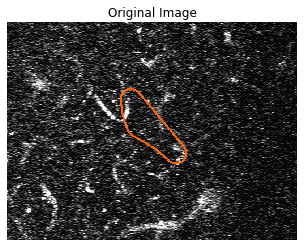

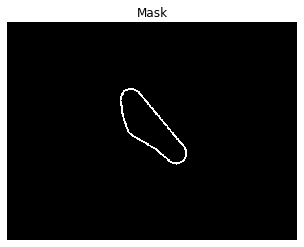

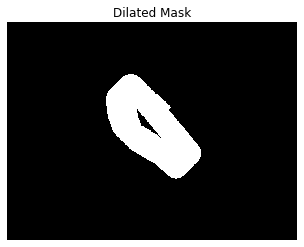

(slice(91, 276, None), slice(174, 342, None))


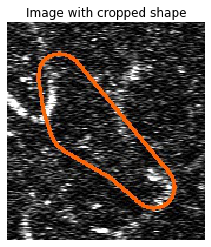

(slice(101, 165, None), slice(42, 207, None))


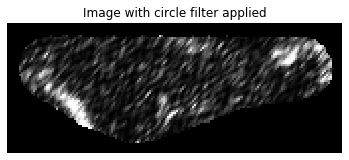

67


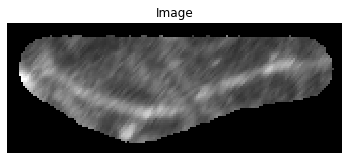

100109.mp4


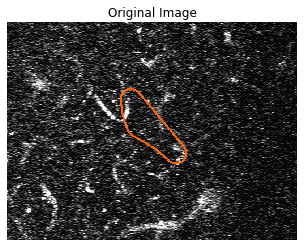

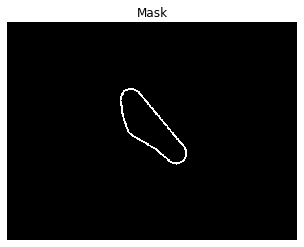

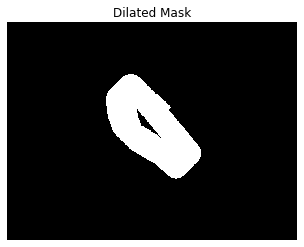

(slice(91, 276, None), slice(174, 342, None))


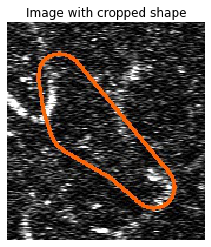

(slice(101, 165, None), slice(42, 207, None))


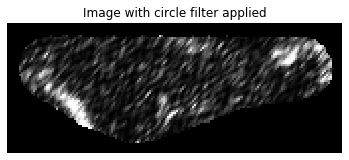

67


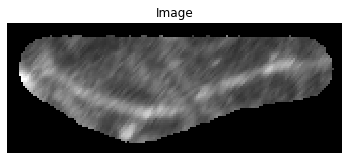


1
100289.mp4


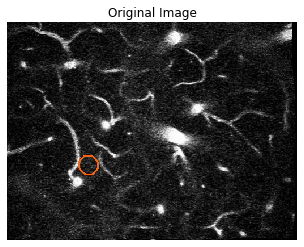

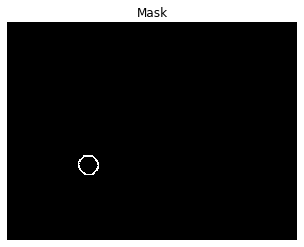

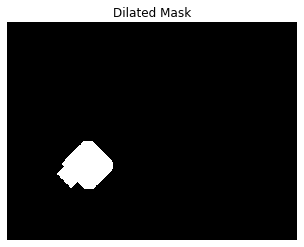

(slice(209, 294, None), slice(88, 186, None))


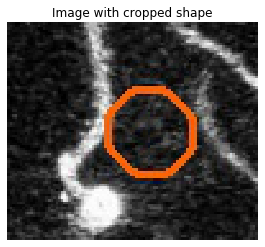

(slice(42, 77, None), slice(52, 89, None))


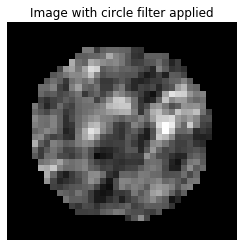

59


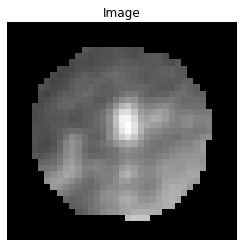

100289.mp4


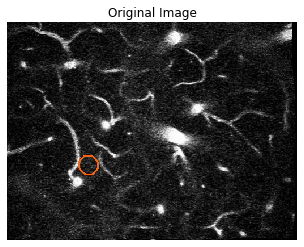

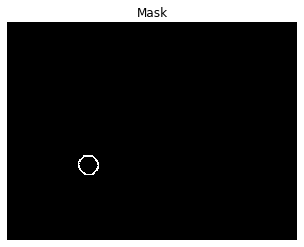

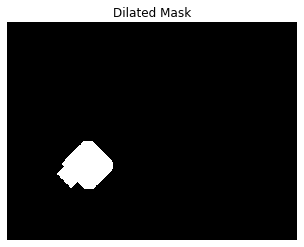

(slice(209, 294, None), slice(88, 186, None))


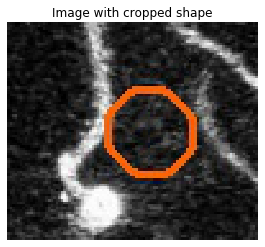

(slice(42, 77, None), slice(52, 89, None))


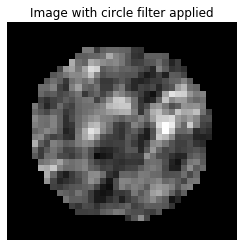

59


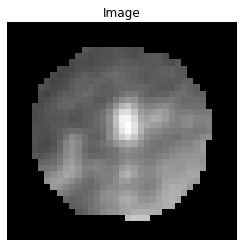


2
100588.mp4


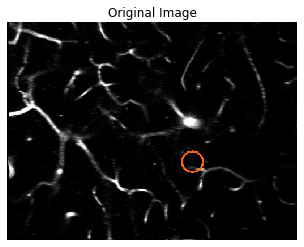

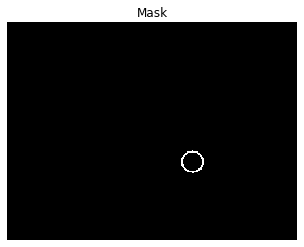

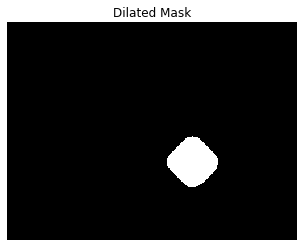

(slice(201, 290, None), slice(282, 372, None))


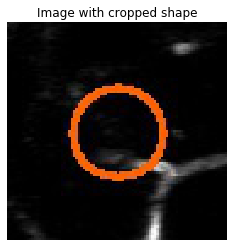

(slice(38, 77, None), slice(38, 78, None))


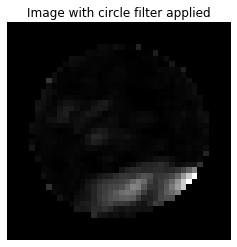

53


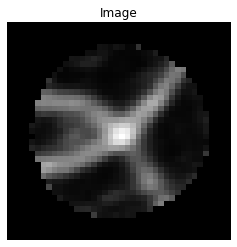

100588.mp4


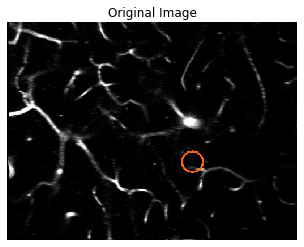

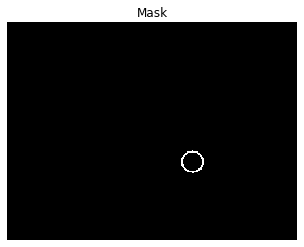

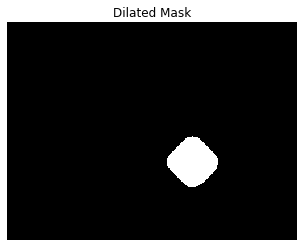

(slice(201, 290, None), slice(282, 372, None))


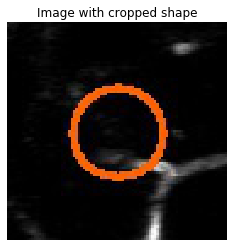

(slice(38, 77, None), slice(38, 78, None))


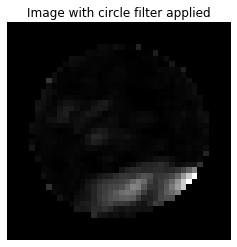

53


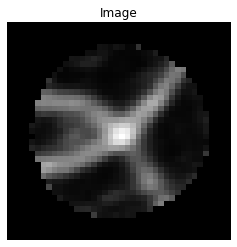


3
100750.mp4


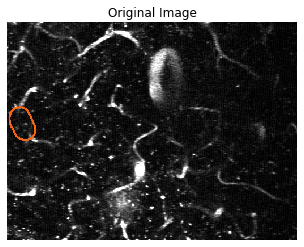

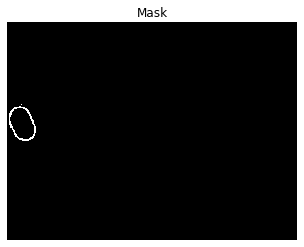

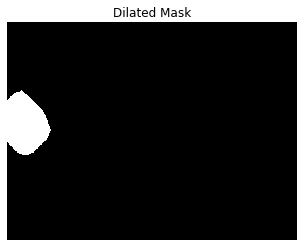

(slice(120, 234, None), slice(0, 76, None))


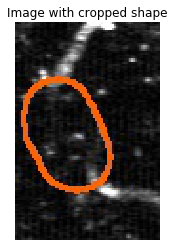

(slice(45, 88, None), slice(32, 97, None))


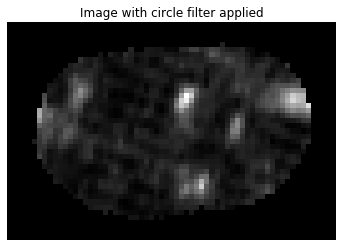

63


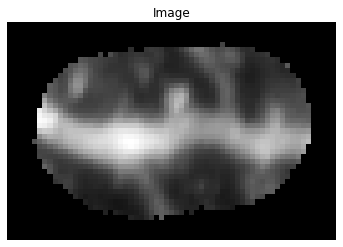

100750.mp4


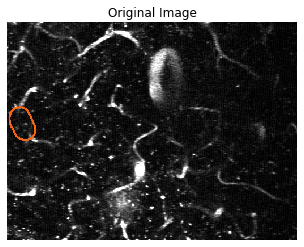

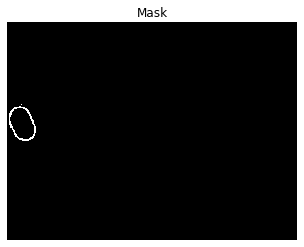

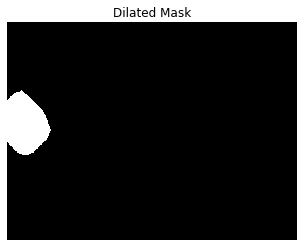

(slice(120, 234, None), slice(0, 76, None))


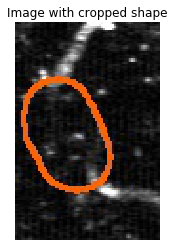

(slice(45, 88, None), slice(32, 97, None))


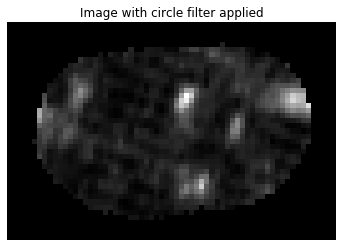

63


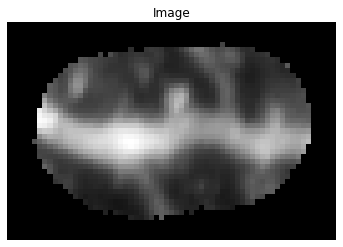


4
102393.mp4


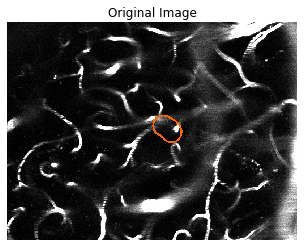

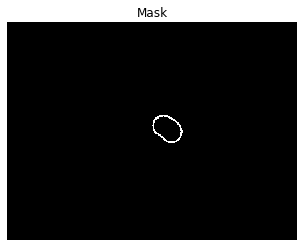

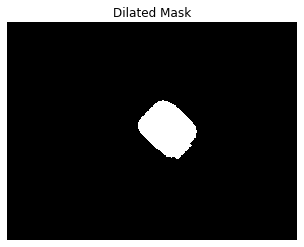

(slice(138, 242, None), slice(231, 334, None))


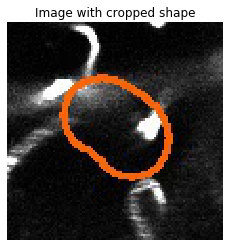

(slice(49, 91, None), slice(43, 101, None))


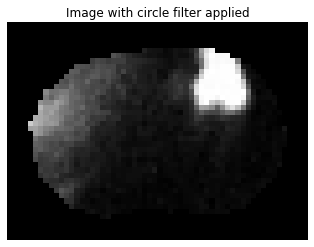

66


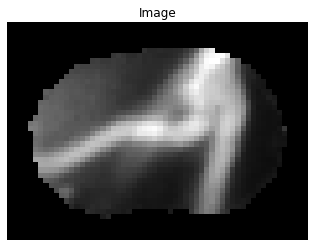

102393.mp4


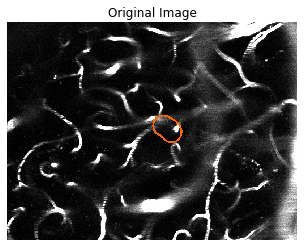

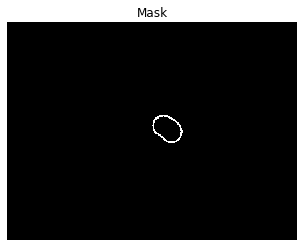

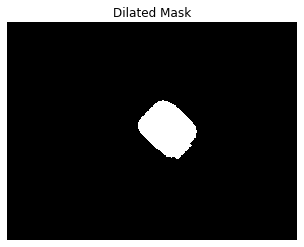

(slice(138, 242, None), slice(231, 334, None))


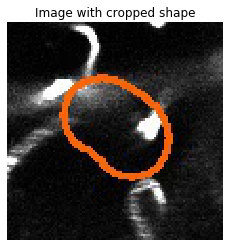

(slice(49, 91, None), slice(43, 101, None))


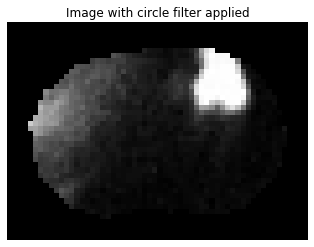

66


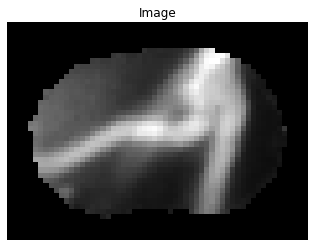

In [64]:
for idx in np.arange(0,5,1): # For demo purposes
#for idx in np.arange(0,len(movies),1): 
    print("\n"+str(idx))
    try:
        preprocessMovie(idx)
    except:
        print("Something went wrong")
    else:
        preprocessMovie(idx)

In [ ]:
# Extract circled area from all frames and sum result

#print(myRot)
#print(mySlice)
allFrames= os.listdir("nano_temp/")
allFrames= list(filter(lambda k: 'frame' in k, allFrames))

finals= []
array_dims= [final_image.shape[0],final_image.shape[1],len(allFrames)]
fmat= np.zeros(array_dims)
print(fmat.shape)

    



In [ ]:
plt.hist(theSum.ravel())

In [8]:
idx=0

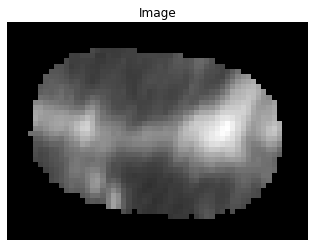

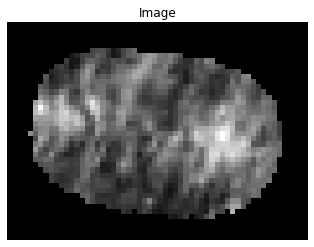

In [250]:
theSum= sum(finals)
show_image(theSum)
theMax= np.max(fmat,axis=2)
show_image(theMax)


In [26]:
red80= np.percentile(image[:,:,0],80)
print(red80)

77.0


In [59]:
def find_cropShape():
    allFrames= os.listdir("nano_temp/")
    allFrames= list(filter(lambda k: 'frame' in k, allFrames))
    #print(len(allFrames))

    image= plt.imread("nano_temp/"+allFrames[0])
    show_image(image)

    red90= np.percentile(image[:,:,0],90)

    mask= np.where((image[:,:,0] > red90) & (image[:,:,2] < red90), 1, 0)
    show_image(mask)
    mask= mask + 0
    rr= np.where(np.sum(mask, axis= 0) > 0)
    cc= np.where(np.sum(mask, axis= 1) > 0)

    cropShape = np.s_[np.min(cc):np.max(cc), np.min(rr):np.max(rr), :]

    cropped_image= image[cropShape]
    show_image(cropped_image)

    return(cropShape, cropped_image)

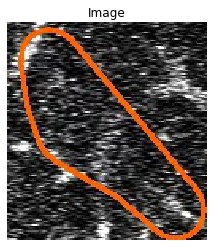

In [13]:
def get_boxSlice(rotated_image):

    # Find the bounding box on the rotated image

    rotated_mask = (rotated_image[:,:,0] > 0.6) & (rotated_image[:,:,1] < 0.6)
    #show_image(rotated_mask)
    labels, nlabels = ndi.label(rotated_mask)
    unique, counts = np.unique(labels, return_counts=True)
    counts[0]= 0
    myObject= np.argmax(counts)
    #print(myObject)
    label_mask = np.where(labels == myObject, 1, 0)
    bboxes = ndi.find_objects(label_mask)
    out_image = rotated_image[bboxes[0]]
    #show_image(out_image)

    mySlice= bboxes[0]
    print(mySlice)
    return(mySlice, out_image)
   

In [12]:
def get_circleFilter(out_image):
    # Remove the coloured circle
    # Make the image grey
    # Limit image to only the contents of the circle
    binary = (out_image[:,:,0] > 0.6) & (out_image[:,:,2] < 0.3)
    #show_image(binary)
    binary = morphology.binary_dilation(binary)
    swap =  1 - binary
    #show_image(swap)

    labels, nlabels = ndi.label(swap)
    unique, counts = np.unique(labels, return_counts=True)
    counts[0]= 0
    myObject= np.argmax(counts)
    grey_image= color.rgb2gray(out_image)
    myCircleFilter= (labels == myObject)
    
    final_image = np.where(myCircleFilter, grey_image, 0)
    show_image(final_image, "Image with circle filter applied")
    return (myCircleFilter, final_image)


(array([2486.,   77.,   67.,   84.,   64.,   61.,   40.,   28.,   19.,
          14.]),
 array([ 0.        ,  6.23182739, 12.46365478, 18.69548217, 24.92730956,
        31.15913695, 37.39096434, 43.62279173, 49.85461912, 56.08644652,
        62.31827391]),
 <a list of 10 Patch objects>)

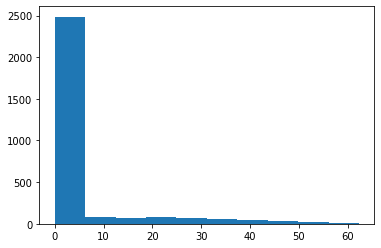

In [175]:
plt.hist(theSum.ravel())

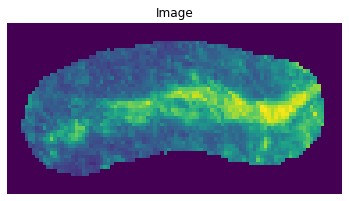

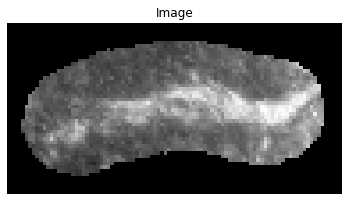

In [388]:
show_image(new_im)
new_im.shape

bw_im= color.rgb2gray(new_im)
show_image(bw_im)

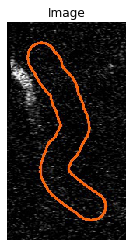

In [347]:
show_image(cropped_image)

In [10]:
myMovie= expand_movie(idx)

100109.mp4


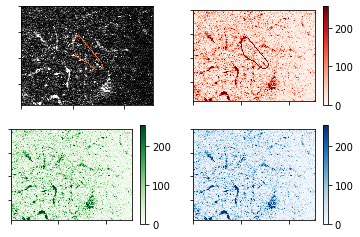

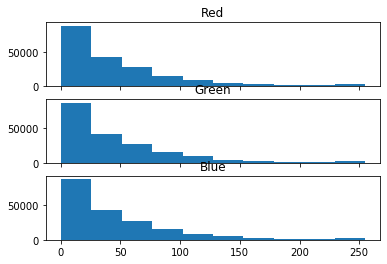

In [25]:
import skimage.io as io
import matplotlib.pyplot as plt

# Read
img = io.imread("nano_temp/"+allFrames[0])

# Split
red = img[:, :, 0]
green = img[:, :, 1]
blue = img[:, :, 2]

# Plot
fig, axs = plt.subplots(2,2)

cax_00 = axs[0,0].imshow(img)
axs[0,0].xaxis.set_major_formatter(plt.NullFormatter())  # kill xlabels
axs[0,0].yaxis.set_major_formatter(plt.NullFormatter())  # kill ylabels

cax_01 = axs[0,1].imshow(red, cmap='Reds')
fig.colorbar(cax_01, ax=axs[0,1])
axs[0,1].xaxis.set_major_formatter(plt.NullFormatter())
axs[0,1].yaxis.set_major_formatter(plt.NullFormatter())

cax_10 = axs[1,0].imshow(green, cmap='Greens')
fig.colorbar(cax_10, ax=axs[1,0])
axs[1,0].xaxis.set_major_formatter(plt.NullFormatter())
axs[1,0].yaxis.set_major_formatter(plt.NullFormatter())

cax_11 = axs[1,1].imshow(blue, cmap='Blues')
fig.colorbar(cax_11, ax=axs[1,1])
axs[1,1].xaxis.set_major_formatter(plt.NullFormatter())
axs[1,1].yaxis.set_major_formatter(plt.NullFormatter())
plt.show()

# Plot histograms
fig, axs = plt.subplots(3, sharex=True, sharey=True)

axs[0].hist(red.ravel(), bins=10)
axs[0].set_title('Red')
axs[1].hist(green.ravel(), bins=10)
axs[1].set_title('Green')
axs[2].hist(blue.ravel(), bins=10)
axs[2].set_title('Blue')

plt.show()